# Hybrid Model: Classification + Regression
- Abandoned this course. Focusing on regression improvements.

- Classify: popularity of 0 or not
- Regression: what's the non-zero
 popularity score
<br>

- Classify scores to 0 (score is 0) or 1 (score is not 0)
- For those we classified as 0, we use that prediction for the final output
- For those > 0, we run a regression model and predict popularity score
- Different y for each problem ("Popularity" vs "class")
- train with the same data? Or adding an "is 0" feature to the training set for popularity score predictions
- what to use classification predictions? The confirmed True Negatives? All predicted negatives?

In [523]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [524]:
df = pd.read_csv("data/dataModel.csv")

## class variable is 0 or 1 for our classification framing. We can use this as our dependent variable
df["class"] = df.Popularity.apply(lambda x: 0.0 if x == 0.0 else 1.0)

In [525]:
df.shape
df["class"].value_counts()

1.0    6574
0.0    1926
Name: class, dtype: int64

## Binary Classification Task

In [526]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
import xgboost as xgb

In [527]:
def eval_classification(y_true, preds):
    cr = classification_report(y_true, preds)
    f1 = f1_score(y_true, preds, average='weighted')
    cm = confusion_matrix(y_true, preds)
    tn, fp, fn, tp = cm.ravel()
    # print(cm.ravel())
    specificity = tn / (tn+fp)

    print("\nClassification Report:")
    print(cr)
    print("\nWeighted F1 Score:")
    print(f1)
    print("\nConfusion Matrix:")
    print(cm)
    # print("Specificity: ", specificity)

    return None

In [528]:
X = df.drop(["class", "Popularity"], axis=1)
print("X shape:", X.shape)

imp = IterativeImputer(n_nearest_features=10)
X = imp.fit_transform(X)

y = df["class"]

X shape: (8500, 17)


In [529]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                     random_state=699, stratify=y)

In [537]:
## DUMMY CLASSIFIER
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)

dummy_preds = dummy.predict(X_test)

print(confusion_matrix(y_test, dummy_preds))
print(classification_report(y_test, dummy_preds))
print(f1_score(y_test, dummy_preds, average="weighted"))

[[  88  297]
 [ 304 1011]]
              precision    recall  f1-score   support

         0.0       0.22      0.23      0.23       385
         1.0       0.77      0.77      0.77      1315

    accuracy                           0.65      1700
   macro avg       0.50      0.50      0.50      1700
weighted avg       0.65      0.65      0.65      1700

0.6475913310992139


In [538]:
## SMOTE sampling
from imblearn.over_sampling import SMOTE
sm = SMOTE()

## .fit_resample to oversample using SMOTE technique
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

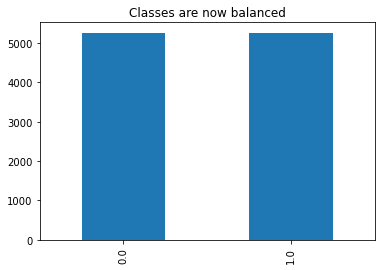

In [539]:
# observe that data has been balanced
pd.Series(y_train_smote).value_counts().plot.bar(title="Classes are now balanced");

In [540]:
## DUMMY WITH SMOTE
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train_smote, y_train_smote)

dummy_preds = dummy.predict(X_test)

print(confusion_matrix(y_test, dummy_preds))
print(classification_report(y_test, dummy_preds))
print(f1_score(y_test, dummy_preds, average="weighted"))


[[189 196]
 [672 643]]
              precision    recall  f1-score   support

         0.0       0.22      0.49      0.30       385
         1.0       0.77      0.49      0.60      1315

    accuracy                           0.49      1700
   macro avg       0.49      0.49      0.45      1700
weighted avg       0.64      0.49      0.53      1700

0.5305238843056861


In [580]:
def model_performances(classifier, param_grid, sampling=True):
    """
    Compare performances of different given classifiers, with and without SMOTE sampling
    :param classifier: sklearn classifier object
    :param param_grid: parameter grid for the appropriate classifier
    :param sampling: Binary, whether to use SMOTE sampling or not
    :return: None
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('clf', classifier)
    ])

    ## performance without sampling
    if not sampling:
        print(f"\n{classifier} Performance without sampling...")
        grid = GridSearchCV(pipeline, param_grid=param_grid, scoring="f1", n_jobs=-1)
        grid.fit(X_train, y_train)

        predictions = grid.predict(X_test)
        print(f"Best params: {grid.best_params_}")
        print(eval_classification(y_test, predictions))

    ## performance with sampling
    else:
        print(f"\n{classifier} Performance with SMOTE sampling...")
        grid2 = GridSearchCV(pipeline, param_grid=param_grid, scoring="f1", n_jobs=-1)
        grid2.fit(X_train_smote, y_train_smote)


        predictions2 = grid2.predict(X_test)
        print(f"Best params: {grid2.best_params_}")
        print(eval_classification(y_test, predictions2))

    return None

In [546]:
## define parameters for grid search

params_LR = {'pca__n_components': np.arange(10, len(df.columns), step=2),
             'clf__class_weight': ["balanced", None],
             'clf__C': [0.01, 0.1, 1.0, 3.0],
             'clf__penalty': ['l1', 'l2']}
params_RF = {'pca__n_components': np.arange(10, len(df.columns), step=2),
             'clf__class_weight': ["balanced", None],
             'clf__n_estimators': [100, 300, 500, 800, 1200],
             'clf__max_depth': [5, 8, 15, 20],
             'clf__min_samples_split': [2, 5, 10],
             'clf__max_features': ["auto", None]}
params_KNN = {'pca__n_components':np.arange(10, len(df.columns), step=2),
              'clf__n_neighbors': [2, 5, 10, 12],
              'clf__weights': ["uniform", "distance"]}
params_ADA = {'pca__n_components': np.arange(10, len(df.columns), step=2),
              'clf__n_estimators': [50, 100, 250],
              'clf__base_estimator': [DecisionTreeClassifier(), SVC(probability=True)]}
params_MLP = {'pca__n_components':np.arange(10, len(df.columns), step=2),
              'clf__activation': ['relu','tanh','logistic','identity'],
              'clf__hidden_layer_sizes': [(100,), (150, 100, 50), (32, 16, 8)]}
params_XGB = {'pca__n_components':np.arange(10, len(df.columns), step=2),
              'clf__objective': ['reg:logistic','binary:hinge'],
              'clf__min_child_weight': [1,5,10],
              'clf__gamma': [0.5, 1.0, 1.5, 2.0],
              'clf__subsample': [0.6, 0.8, 1.0],
              'clf__max_depth': [3,4,5],
              'clf__booster': ["gbtree", "gblinear", "dart"]}

In [547]:
## get list of regression, make dict with params_dict as value
# RF takes a lot, screenshot with results capture
try_clfs = [LogisticRegression(),
            RandomForestClassifier(),
            KNeighborsClassifier(),
            AdaBoostClassifier(),
            MLPClassifier(),
            xgb.XGBClassifier()]

s_dict = {}
s_dict[try_clfs[0]] = params_LR
# s_dict[try_clfs[1]] = params_RF
s_dict[try_clfs[2]] = params_KNN
s_dict[try_clfs[3]] = params_ADA
s_dict[try_clfs[4]] = params_MLP
s_dict[try_clfs[5]] = params_XGB

In [548]:
## run the gridsearch for every model
for clf, params in s_dict.items():
    # print(v)
    model_performances(clf, params)


LogisticRegression() Performance without sampling...
Best params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2', 'pca__n_components': 12}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.02      0.03       385
         1.0       0.78      0.99      0.87      1315

    accuracy                           0.77      1700
   macro avg       0.57      0.50      0.45      1700
weighted avg       0.68      0.77      0.68      1700


Weighted F1 Score:
0.6806843214754209

Confusion Matrix:
[[   7  378]
 [  12 1303]]
None
LogisticRegression() Performance with SMOTE sampling...
Best params: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'pca__n_components': 10}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.76      0.50       385
         1.0       0.90      0.62      0.73      1315

    accuracy                           0.65    

/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.71370371
 0.70915934 0.70453039 0.70482119        nan        nan        nan
        nan        nan        nan 0.87044432 0.87123491 0.87103358
 0.87023361        nan        nan        nan        nan        nan
        nan 0.71273671 0.70841966 0.70415582 0.70497527        nan
        nan        nan        nan        nan        nan 0.86972297
 0.87028486 0.86804762 0.86906872        nan        nan        nan
        nan        nan        nan 0.71244278 0.70856792 0.70430708
 0.70504117        nan        nan        nan        nan        nan
        nan 0.86984674 0.87007355 0.86805321 0.86903076        nan
        nan        nan        nan        nan        nan 0.71244278
 0.70856792 0.70430708 0.70504117        nan        nan        nan
        nan        nan        nan 0.86984674

Findings:
- SMOTE helps in our model performance
- Best performing models: Random Forest (best), MLP (), XGBoost (Stacking Classifier?)
- Best performing PCA components all hover around 14-16
-

In [591]:
### pick estimators to stack based on performance on previous experiment (above)

estimators = [
        ('est1', RandomForestClassifier(class_weight="balanced", max_depth=20,
                                        max_features="auto", min_samples_split=5,
                                        random_state=699)),
        ('est2', MLPClassifier(activation="relu", hidden_layer_sizes=(150,100,50),
                                random_state=699)),
        ('est3', xgb.XGBClassifier(booster="dart", gamma=1.5, max_depth=5,
                                   min_child_weight=1, objective="reg:logistic",
                                   subsample=0.8)),
        ('est4', LinearSVC(class_weight="balanced", random_state=699))]

stack_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(class_weight="balanced"))

In [592]:
# Best params: {'clf__booster': 'dart', 'clf__gamma': 1.5, 'clf__max_depth': 5, 'clf__min_child_weight': 1, 'clf__objective': 'reg:logistic', 'clf__subsample': 0.8, 'pca__n_components': 16}
# Best params: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (150, 100, 50), 'pca__n_components': 16}

# clf.fit(X_train, y_train)
stack_clf.fit(X_train_smote, y_train_smote)
stack_clf_preds = stack_clf.predict(X_test)

eval_classification(y_test, stack_clf_preds)

/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Enc


Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.39      0.41       385
         1.0       0.83      0.85      0.84      1315

    accuracy                           0.74      1700
   macro avg       0.63      0.62      0.62      1700
weighted avg       0.74      0.74      0.74      1700


Weighted F1 Score:
0.7390468865179548

Confusion Matrix:
[[ 151  234]
 [ 203 1112]]


In [579]:
# params_STACK = {'pca__n_components': [16]}

# eval_classification(y_test, stack_clf_preds)
# model_performances(stack_clf, param_grid=params_STACK)


StackingClassifier(estimators=[('est1',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       min_samples_split=5,
                                                       random_state=699)),
                               ('est2',
                                MLPClassifier(hidden_layer_sizes=(150, 100, 2),
                                              learning_rate='adaptive',
                                              random_state=699)),
                               ('est3',
                                XGBClassifier(base_score=None, booster='dart',
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=...
                                              monotone_constraints=None,
   

/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Enc

In [600]:
print(len(stack_clf_preds))

stack_clf.fit(X, y)
full_preds = stack_clf.predict(X)

1700


/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/envs/MSD/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Enc

In [602]:
df["score_prediction"] = full_preds
df

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,class,score_prediction
0,2678,0.591,0.372,2008,19.0,0.6560,0.4870,0.0,-9.344,1.0,0.0360,0.077800,0.056300,0.108,0.0385,123.974,148701.0,4.0,1.0,1.0
1,1735,0.429,0.533,2004,3.0,0.3410,0.3160,1.0,-8.922,0.0,0.0335,0.886000,0.000012,0.104,0.1680,80.283,253000.0,4.0,1.0,1.0
2,3176,0.000,0.000,0,4.0,0.5140,0.2030,7.0,-15.443,1.0,0.0350,0.906000,0.830000,0.139,0.5400,83.179,240400.0,4.0,1.0,1.0
3,1441,0.380,0.369,2007,1.0,0.1920,0.9870,1.0,-5.382,1.0,0.1110,0.000011,0.681000,0.818,0.2020,103.886,138760.0,4.0,1.0,1.0
4,2456,0.551,1.000,0,0.0,0.3340,0.2000,10.0,-15.672,1.0,0.0371,0.925000,0.694000,0.112,0.3200,119.185,199784.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,464,0.444,0.243,0,0.0,0.6910,0.8570,7.0,-5.879,1.0,0.0315,0.155000,0.000006,0.212,0.9050,143.004,237160.0,4.0,0.0,0.0
8496,3510,0.756,0.536,1981,44.0,0.4710,0.0365,9.0,-18.460,0.0,0.0608,0.959000,0.808000,0.099,0.1180,172.646,141040.0,4.0,1.0,1.0
8497,3681,0.180,0.307,2007,23.0,0.5540,0.9260,2.0,-6.306,1.0,0.0775,0.000040,0.000070,0.338,0.3790,109.994,203430.0,4.0,1.0,1.0
8498,996,0.042,0.484,2007,39.0,0.6810,0.5920,8.0,-12.565,1.0,0.0717,0.089900,0.018000,0.103,0.6720,79.943,238600.0,4.0,1.0,1.0


In [605]:
df[["score_prediction", "Popularity"]]
df

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,class,score_prediction
0,2678,0.591,0.372,2008,19.0,0.6560,0.4870,0.0,-9.344,1.0,0.0360,0.077800,0.056300,0.108,0.0385,123.974,148701.0,4.0,1.0,1.0
1,1735,0.429,0.533,2004,3.0,0.3410,0.3160,1.0,-8.922,0.0,0.0335,0.886000,0.000012,0.104,0.1680,80.283,253000.0,4.0,1.0,1.0
2,3176,0.000,0.000,0,4.0,0.5140,0.2030,7.0,-15.443,1.0,0.0350,0.906000,0.830000,0.139,0.5400,83.179,240400.0,4.0,1.0,1.0
3,1441,0.380,0.369,2007,1.0,0.1920,0.9870,1.0,-5.382,1.0,0.1110,0.000011,0.681000,0.818,0.2020,103.886,138760.0,4.0,1.0,1.0
4,2456,0.551,1.000,0,0.0,0.3340,0.2000,10.0,-15.672,1.0,0.0371,0.925000,0.694000,0.112,0.3200,119.185,199784.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,464,0.444,0.243,0,0.0,0.6910,0.8570,7.0,-5.879,1.0,0.0315,0.155000,0.000006,0.212,0.9050,143.004,237160.0,4.0,0.0,0.0
8496,3510,0.756,0.536,1981,44.0,0.4710,0.0365,9.0,-18.460,0.0,0.0608,0.959000,0.808000,0.099,0.1180,172.646,141040.0,4.0,1.0,1.0
8497,3681,0.180,0.307,2007,23.0,0.5540,0.9260,2.0,-6.306,1.0,0.0775,0.000040,0.000070,0.338,0.3790,109.994,203430.0,4.0,1.0,1.0
8498,996,0.042,0.484,2007,39.0,0.6810,0.5920,8.0,-12.565,1.0,0.0717,0.089900,0.018000,0.103,0.6720,79.943,238600.0,4.0,1.0,1.0
